In [1]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from nirs4all.dataset import DatasetConfigs
from nirs4all.operators.transformations import *
from nirs4all.pipeline import PipelineConfigs, PipelineRunner
from sklearn.ensemble import RandomForestRegressor

x_scaler = MinMaxScaler() # StandardScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer(), LogTransform()
y_scaler = MinMaxScaler()
list_of_preprocessors = [ Detrend, FirstDerivative, SecondDerivative, Gaussian, StandardNormalVariate, SavitzkyGolay, Haar, MultiplicativeScatterCorrection]
splitting_strategy = ShuffleSplit(n_splits=3, test_size=.25)
dataset_folder = '../../sample_data/regression'

pipeline = [
    # "chart_2d",
    x_scaler,
    # "chart_3d",
    {"y_processing": y_scaler},
    {"feature_augmentation": { "_or_": list_of_preprocessors, "size":[1,(1,2)], "count":5 }}, # Generate all elements of size 1 and of order 1 or 2 (ie. "Gaussian", ["SavitzkyGolay", "Log"], etc.)
    splitting_strategy,
]

for i in range(10, 30, 10):
    model = {
        "name": f"PLS-{i}_cp",
        "model": PLSRegression(n_components=i)
    }
    pipeline.append(model)

pipeline_config = PipelineConfigs(pipeline, "pipeline_Q1")
dataset_config = DatasetConfigs(dataset_folder)

# Create pipeline with verbose=1 to see debug output
runner = PipelineRunner(save_files=True, verbose=1)
run_predictions, other_predictions = runner.run(pipeline_config, dataset_config)

🚀 Starting pipeline run with 5 pipeline configuration(s) on 1 dataset configuration(s) (5 total runs).
✅ Loaded dataset 'regression' with 130 training and 59 test samples.
📊 Dataset: regression
Features (samples=189, sources=1):
- Source 0: (189, 1, 2151), processings=['raw'], min=-0.265, max=1.436, mean=0.466, var=0.149)
Targets: (samples=189, targets=1, processings=['numeric'])
- numeric: min=1.33, max=128.31, mean=30.779
Indexes:
- "train", ['raw']: 130 samples
- "test", ['raw']: 59 samples
📥 Loaded 732 predictions from results\regression\regression_predictions.json
🚀 Starting pipeline config_pipeline_Q1_32737a on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: {'class': 'sklearn.preprocessing._data.MinMaxScaler', '_runtime_instance': MinMaxScaler()}
🔹 Executing controller TransformerMixinController with

Found 30 aggregated test models:
  - PLS-10_cp_step5_avg (fold_idx: avg)
  - PLS-10_cp_step5_w_avg (fold_idx: w_avg)
  - PLS-10_cp_step6_avg (fold_idx: avg)
  - PLS-10_cp_step6_w_avg (fold_idx: w_avg)
  - PLS-20_cp_step6_avg (fold_idx: avg)
  - PLS-20_cp_step6_w_avg (fold_idx: w_avg)
  - PLS-10_cp_step5_avg (fold_idx: avg)
  - PLS-10_cp_step5_w_avg (fold_idx: w_avg)
  - PLS-10_cp_step6_avg (fold_idx: avg)
  - PLS-10_cp_step6_w_avg (fold_idx: w_avg)
  - PLS-20_cp_step6_avg (fold_idx: avg)
  - PLS-20_cp_step6_w_avg (fold_idx: w_avg)
  - PLS-10_cp_step5_avg (fold_idx: avg)
  - PLS-10_cp_step5_w_avg (fold_idx: w_avg)
  - PLS-10_cp_step6_avg (fold_idx: avg)
  - PLS-10_cp_step6_w_avg (fold_idx: w_avg)
  - PLS-20_cp_step6_avg (fold_idx: avg)
  - PLS-20_cp_step6_w_avg (fold_idx: w_avg)
  - PLS-10_cp_step5_avg (fold_idx: avg)
  - PLS-10_cp_step5_w_avg (fold_idx: w_avg)
  - PLS-10_cp_step6_avg (fold_idx: avg)
  - PLS-10_cp_step6_w_avg (fold_idx: w_avg)
  - PLS-20_cp_step6_avg (fold_idx: avg)
  -

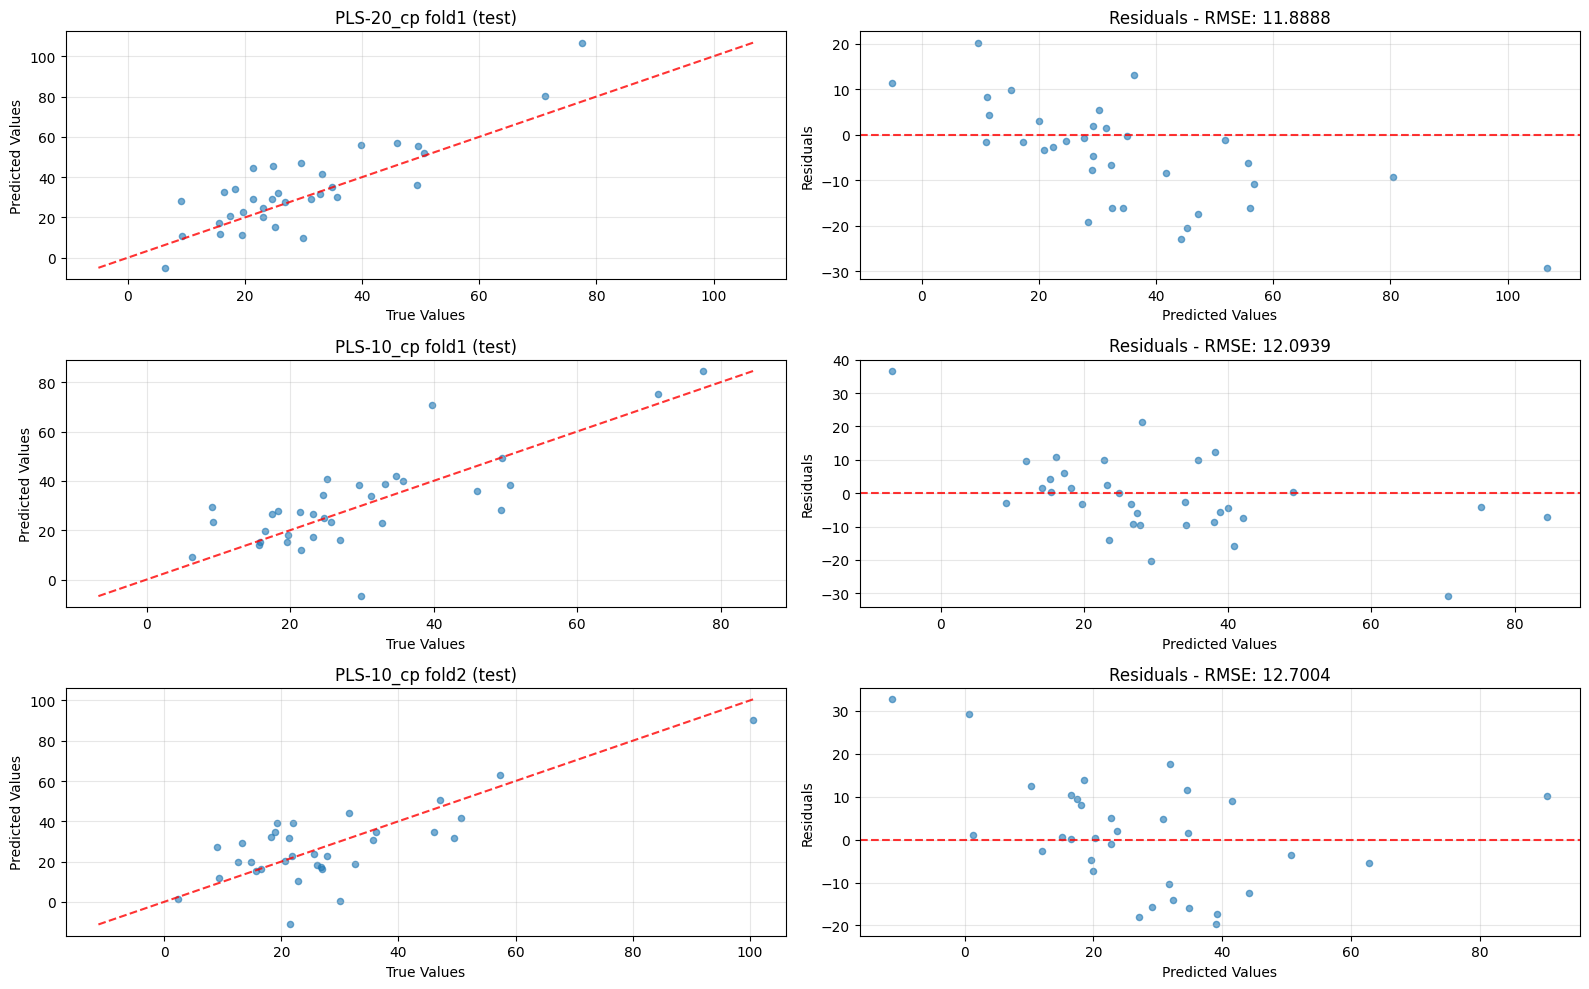

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from nirs4all.dataset.prediction_analyzer import PredictionAnalyzer

analyzer = PredictionAnalyzer(run_predictions)

# Look specifically for aggregated models (avg and w_avg)
aggregated_models = []
individual_models = []

for key, pred in run_predictions._predictions.items():
    real_model = pred.get('real_model', '')
    fold_idx = pred.get('fold_idx', '')
    partition = pred.get('partition', '')

    if fold_idx in ['avg', 'w_avg'] and partition == 'test':
        aggregated_models.append({
            'key': key,
            'real_model': real_model,
            'fold_idx': fold_idx,
            'partition': partition
        })
    elif isinstance(fold_idx, int) and partition == 'test':
        individual_models.append({
            'key': key,
            'real_model': real_model,
            'fold_idx': fold_idx,
            'partition': partition
        })

print(f"Found {len(aggregated_models)} aggregated test models:")
for model in aggregated_models:
    print(f"  - {model['real_model']} (fold_idx: {model['fold_idx']})")

print(f"\nFound {len(individual_models)} individual fold test models:")
for model in individual_models[:10]:  # Show first 10
    print(f"  - {model['real_model']} (fold_idx: {model['fold_idx']})")
if len(individual_models) > 10:
    print(f"  ... and {len(individual_models) - 10} more")

# Get top models including aggregated ones
top_20 = analyzer.get_top_k(20, 'mse')
print(f"\nTop 20 models by MSE:")
for i, model in enumerate(top_20, 1):
    enhanced_name = model.get('enhanced_model_name', model.get('real_model', 'unknown'))
    real_model = model.get('real_model', 'unknown')
    fold_idx = model.get('fold_idx', 'N/A')
    partition_type = model.get('partition_type', 'N/A')
    print(f"{i}. {enhanced_name} | real: {real_model} | fold: {fold_idx} | partition: {partition_type} | RMSE: {model['metrics']['rmse']:.6f}")

# Plot comparison
fig = analyzer.plot_top_k_comparison(k=3, metric='rmse', partition_type='test')
plt.show()

In [3]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from nirs4all.dataset import DatasetConfigs
from nirs4all.operators.transformations import *
from nirs4all.pipeline import PipelineConfigs, PipelineRunner

x_scaler = MinMaxScaler() # StandardScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer(), LogTransform()
list_of_preprocessors = [ Detrend, FirstDerivative, SecondDerivative, Gaussian, StandardNormalVariate, SavitzkyGolay, Haar, MultiplicativeScatterCorrection]
splitting_strategy = ShuffleSplit(n_splits=3, test_size=.25)
dataset_folder = '../../sample_data/classification'

pipeline = [
    "chart_2d",
    x_scaler,
    "chart_3d",
    {"feature_augmentation": { "_or_": list_of_preprocessors, "size":[1,(1,2)], "count":5 }}, # Generate all elements of size 1 and of order 1 or 2 (ie. "Gaussian", ["SavitzkyGolay", "Log"], etc.)
    splitting_strategy,
]

for i in range(5, 20, 5):
    model = {
        "name": f"RF-depth-{i}",
        "model": RandomForestClassifier(max_depth=i)
    }
    pipeline.append(model)

pipeline_config = PipelineConfigs(pipeline, "pipeline_Q1")
dataset_config = DatasetConfigs(dataset_folder)

# Create pipeline
runner = PipelineRunner(save_files=False)
run_predictions, other_predictions = runner.run(pipeline_config, dataset_config)

🚀 Starting pipeline run with 5 pipeline configuration(s) on 1 dataset configuration(s) (5 total runs).
✅ Loaded dataset 'classification' with 48 training and 18 test samples.
🚀 Starting pipeline config_pipeline_Q1_1a90be on dataset classification
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: chart_2d
🔹 Executing controller SpectraChartController without operator
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 2: {'class': 'sklearn.preprocessing._data.MinMaxScaler', '_runtime_instance': MinMaxScaler()}
🔹 Executing controller TransformerMixinController with operator MinMaxScaler
🔄 TransformerMixin (MinMaxScaler)
---------------------------------------------------------

1. RF-depth-10_13 - config_pipeline_Q1_517775 - Accuracy: 0.500000, F1: 0.451190, Precision: 0.486111, Recall: 0.500000
2. RF-depth-5_10 - config_pipeline_Q1_a291af - Accuracy: 0.500000, F1: 0.450000, Precision: 0.437500, Recall: 0.500000
3. RF-depth-15_28 - config_pipeline_Q1_a291af - Accuracy: 0.500000, F1: 0.412698, Precision: 0.354167, Recall: 0.500000
4. RF-depth-5_7 - config_pipeline_Q1_62f62a - Accuracy: 0.416667, F1: 0.496825, Precision: 0.625000, Recall: 0.416667
5. RF-depth-10_16 - config_pipeline_Q1_ff3bcd - Accuracy: 0.416667, F1: 0.388889, Precision: 0.416667, Recall: 0.416667


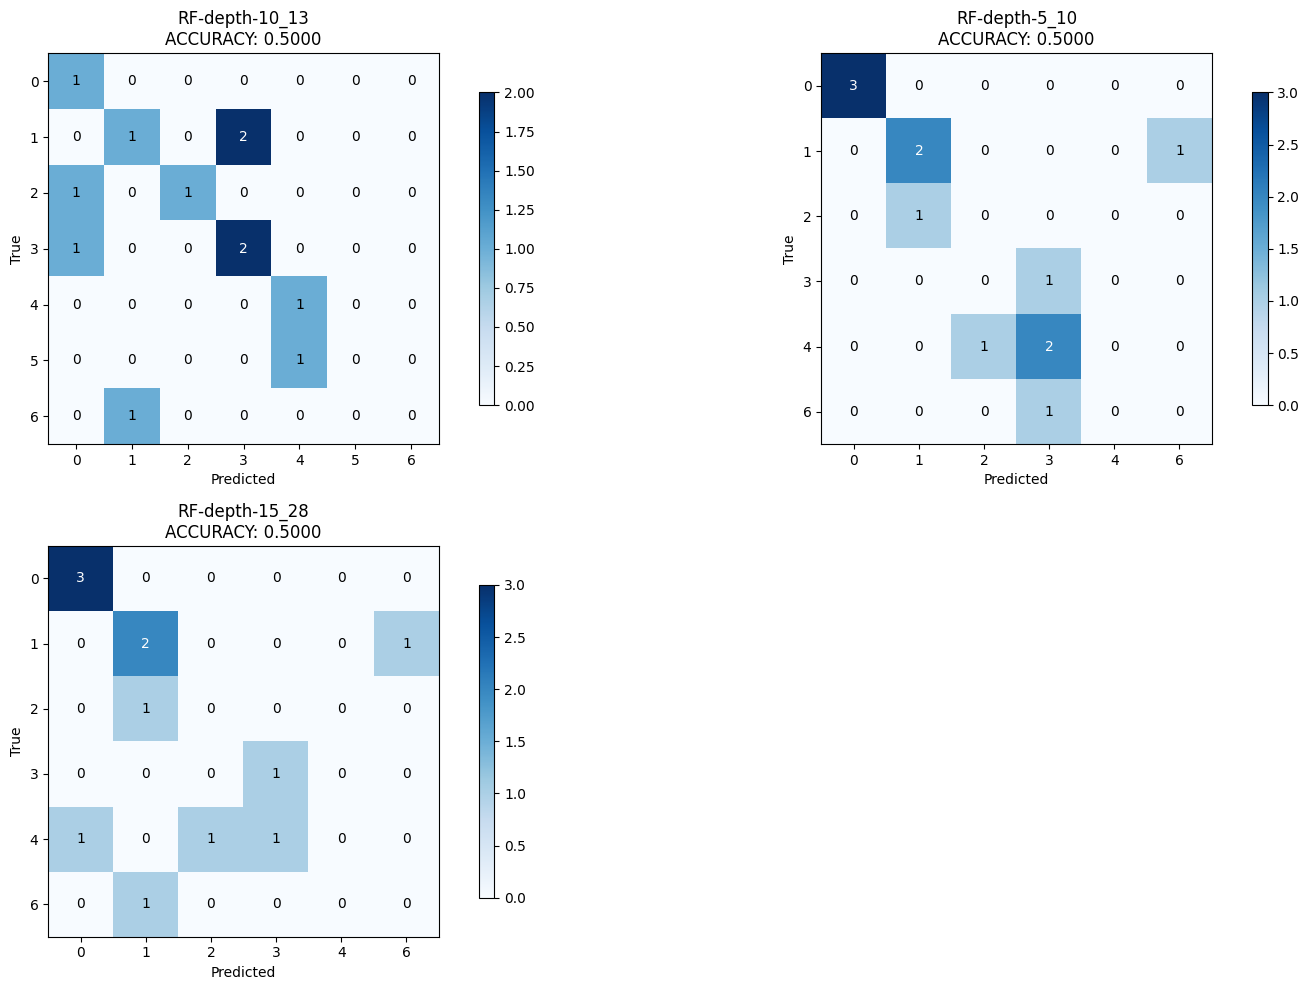

In [4]:
import numpy as np
from nirs4all.dataset.prediction_analyzer import PredictionAnalyzer

analyzer = PredictionAnalyzer(run_predictions)

top_5 = analyzer.get_top_k(5, 'accuracy')
for i, model in enumerate(top_5, 1):
    # Use enhanced_model_name which includes custom names when available
    enhanced_name = model.get('enhanced_model_name', model.get('real_model', 'unknown'))
    # canonical_name = model.get('canonical_model', 'unknown')
    pipeline_path = model.get('path', '')

    # Extract config ID from pipeline path or key
    config_id = "unknown"
    if 'config_' in pipeline_path:
        config_part = pipeline_path.split('config_')[1].split('/')[0] if '/' in pipeline_path else pipeline_path.split('config_')[1]
        config_id = f"config_{config_part}"

    print(f"{i}. {enhanced_name} - {config_id} - Accuracy: {model['metrics']['accuracy']:.6f}, F1: {model['metrics']['f1']:.6f}, Precision: {model['metrics']['precision']:.6f}, Recall: {model['metrics']['recall']:.6f}")

# Plot top_k comparison with enhanced names in titles
fig = analyzer.plot_top_k_confusionMatrix(k=3, metric='accuracy', partition_type='test')
plt.show()